In [2]:
from sys import exc_info
import ast

import pandas as pd
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
# U ovom slucaju cemo ga koristiti za kreiranje rastrkane matrice
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
# Napredni KMeans algoritam koji ima mogucnost postavljanja najmanjeg broja tacaka u klasteru
from k_means_constrained import KMeansConstrained
# Klasa za prepoznavanje optimalnog broja klastera
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
import pickle

## Ucitavamo podatke

In [3]:
ratings = pd.read_csv('datasets/rating.csv', usecols=['userId', 'movieId', 'rating'])
movies = pd.read_csv('datasets/movie.csv', usecols=['movieId', 'title', 'genres'])

Trebamo da smanjimo broj podataka s kojim cemo raditi
Obrada 20 miliona recenzija je previse za nas CPU a  
Recenzije ispod 4.0 ocjene nam nisu potrebne jer nas zanimaju samo oni filmovi koji se korisniku svidjaju

In [4]:
ratings = ratings[ratings['rating'] >= 4.0]

In [5]:
ratings.shape

(9995410, 3)

Skratili smo broj recenzija na skoro 10 miliona, smatram da je to i dalje prevelik broj  
Mozemo se ogranciti na 1500 filmova, smatram da je to dovoljno da bi se prikazale zadovoljavajuce preporuke

In [6]:
unique_movie_ids = np.unique(ratings['movieId'])[:1500]

Slijedi korak gdje cemo uzeti samo recenzije filmova koje smo prethodno filtrirali

In [7]:
ratings = ratings.loc[ratings['movieId'].isin(unique_movie_ids)]
ratings.shape

(4344859, 3)

Isti korak mozemo uraditi i za korisnike, uzet cemo hiljadu korisnika

In [8]:
unique_users_ids = np.unique(ratings['userId'])[:1000]

In [9]:
ratings = ratings.loc[ratings['userId'].isin(unique_users_ids)]
ratings.shape

(31708, 3)

Dobili smo 31708 recenzija, smatram da je ovo dovoljno 

Sada cemo uzeti korisnike sa filmovima koje su ocijenili i resetovati cemo index jer krece od 6

In [10]:
users_with_their_movies = ratings.loc[:,['userId','movieId']]

users_with_their_movies = users_with_their_movies.reset_index(drop=True)
users_with_their_movies.T

,0,1,2,3,4,5,6,7,8,9,...,31698,31699,31700,31701,31702,31703,31704,31705,31706,31707
userId,1,1,1,1,1,1,1,1,1,1,...,1008,1008,1008,1008,1008,1008,1009,1009,1009,1009
movieId,151,223,253,260,293,296,318,541,1036,1079,...,786,788,828,1073,1356,1367,480,1275,1287,1291


In [11]:
# Mozemo sacuvati podatke o korisnicima i filmovima koje su ocijenili da bi ih kasnije mogli koristiti
users_with_their_movies.to_csv('datasets/users_with_their_movies.csv')

In [12]:
# Sljedeci korak je da dobijemo listu u kojoj ce se nalaziti liste filmova
# Index liste ce odgovarati Id-u korisnika
# user_ids - Lista user id-jeva
# users_with_their_movies_df je lista iznad koju smo dobili i sacuvali u fajl
def get_movies_of_users(users_ids, users_with_their_movies_df):
    movies_of_users = []
    for user_id in users_ids:
        movies_of_users.append(
            str(
                list(
                    users_with_their_movies_df[users_with_their_movies_df['userId'] == user_id]['movieId']
                )
            ).split('[')[1].split(']')[0]
        )
    return movies_of_users

In [13]:
# Listu users_ids dobijamo preko np.unique na data frame-u user_rated_movies_df
users_ids = np.unique(users_with_their_movies)
users_ids.shape

(1397,)

Dobili smo da imamo 1397 jedinstvenih korisnika

In [14]:
# Sada pozivom funkcije get_movies_of_users pripremamo ulazni parametar za matricu
users_with_movies_prepared_for_matrix = get_movies_of_users(users_ids, users_with_their_movies)
# Lista izgleda ovako, index 0 odgovara prvom korisniku
users_with_movies_prepared_for_matrix[0:1]

['151, 223, 253, 260, 293, 296, 318, 541, 1036, 1079, 1090, 1097, 1196, 1198, 1200, 1214, 1215, 1219, 1240, 1249, 1258, 1259, 1266, 1278, 1321, 1333, 1358, 1374, 1387']

Prvi korisnik je ocijenio ove filmove

In [15]:
# Inicijalizovati cemo CountVectorizer koji ima mogucnost da kreira rastrkanu matricu
# Da bi kasnije radili predikcije, bitno nam je da nam countVectorizer ostane isti, tako da cemo ga u funkciji vratiti
def create_matrix_from_list(users_with_movies_prepared_for_matrix):
    count_vectorizer = CountVectorizer(token_pattern=r'[^\,\ ]+', lowercase=False)
    matrix_fitted_and_transformed = count_vectorizer.fit_transform(users_with_movies_prepared_for_matrix)
    # Matricu cemo vratiti kao listu, jer nam ovakav objekat ne moze pomoci
    # Izvaditi cemo i filmove preko feature_names takodje
    return count_vectorizer, matrix_fitted_and_transformed.toarray(), count_vectorizer.get_feature_names()

In [16]:
count_vectorizer, matrix, feature_names = create_matrix_from_list(users_with_movies_prepared_for_matrix)

# Obucavanje modela

Iskoristiti cemo dve metode za odredjivanje optimalnog broja klastera

### Davies-Bouldin Index

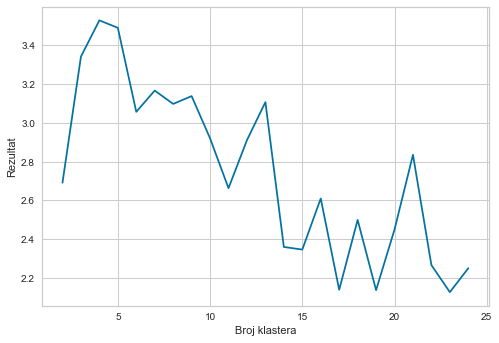

<Figure size 720x720 with 0 Axes>

In [37]:
from sklearn.metrics import davies_bouldin_score

def get_davies_bouldin_scores(matrix, start, stop):    
    # Lista koja ce cuvati sve rezultate
    db_scores = []
    for i in range(start, stop):
        kmeans = KMeans(i)
        kmeans.fit(matrix)
        db_scores.append(davies_bouldin_score(matrix, kmeans.labels_))
    return db_scores

# Rezultate funkcije mozemo isplotovati da pronadjemo lakat
davies_bouldin_scores = get_davies_bouldin_scores(matrix, 2, 25)
davies_bouldin_plot = sns.lineplot(x=list(range(2, 25)), y=davies_bouldin_scores)

plt.figure(figsize=(10, 10))
davies_bouldin_plot.set(xlabel='Broj klastera', ylabel='Rezultat')
plt.show()

Na osnovu Davies-Bouldin Index-a, dobijamo da je optimalan broj klastera negdje oko 5 do 6

### Calinski-Harabasz Index

Imamo biblioteku KElbowVisualizer koja ce nam sama prikazati na kom je broj lakat

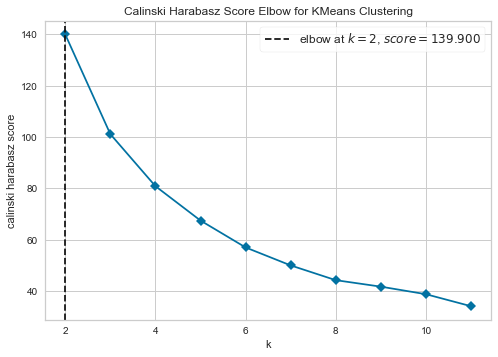

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [39]:
calinski_harabasz_model = KMeans()
calinski_harabasz_visualizer = KElbowVisualizer(calinski_harabasz_model, k=(2, 12), metric='calinski_harabasz', timings=False)
calinski_harabasz_visualizer.fit(matrix)
calinski_harabasz_visualizer.show()

### Silhouette 

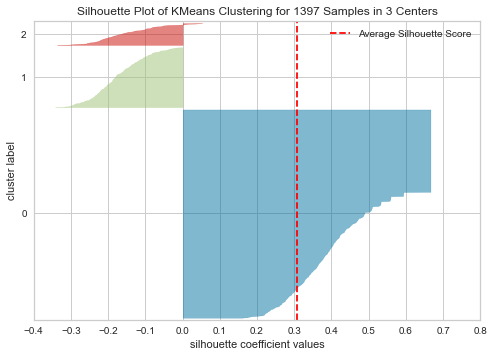

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1397 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [41]:
silhouette_model = KMeans(3, random_state=42)
silhouette_visualizer = SilhouetteVisualizer(silhouette_model, colors='yellowbrick')
silhouette_visualizer.fit(matrix)
silhouette_visualizer.show()

Posto Silhouette koeficijent pokazuje da je optimalan broj klastera 2, uzet cemo sredinu od 4 klastera

Da bi izbjegli problem gdje klasicni KMeans algoritam postavlja klastere koji su mali za bilo kakve preporuke koristit cemo KMeansConstrained

Postaviti cemo da je moguce imati najmanje 150 tacaka u klasteru

In [37]:
kmeans = KMeansConstrained(n_clusters=4, init='k-means++', size_min=150, max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(matrix)

Broj tacaka u svakom klasteru

In [38]:
np.bincount(kmeans.labels_)

array([150, 823, 274, 150])

In [39]:
# Mozemo prikazati korisnike i njihove klastere
users_and_their_clusters_df = pd.DataFrame(np.concatenate((users_ids.reshape(-1,1),clusters.reshape(-1,1)), axis=1), columns = ['userId', 'Cluster'])
users_and_their_clusters_df.T

,0,1,2,3,4,5,6,7,8,9,...,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396
userId,1,2,3,4,5,6,7,8,9,10,...,1537,1539,1541,1542,1544,1545,1546,1549,1550,1551
Cluster,2,2,0,1,3,1,2,3,1,2,...,1,1,1,1,1,1,1,1,1,1


Kada smo rijesili obucavanje modela, mozemo uzeti filmove za koje prethodno uzeli recenzije

In [40]:
movies = movies.loc[movies['movieId'].isin(np.unique(users_with_their_movies['movieId']))].reset_index(drop=True)

In [41]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
1138,1545,Ponette (1996),Drama
1139,1546,Schizopolis (1996),Comedy
1140,1549,Rough Magic (1995),Drama|Romance
1141,1550,Trial and Error (1997),Comedy|Romance


Sad cemo postaviti filmove na osnovu klastera korisnici u zavisnosti koliko svaki klaster sadrzi filmova

In [42]:
def get_movies_clusters_per_users_clusters(users_and_their_clusters_df, users_with_their_movies):
    # users_cluster nam je lista koja pokazuje po rednom broju kom klasteru korisnik pripada
    users_clusters = list(users_and_their_clusters_df['Cluster'])
    each_cluster_movies = []
    for i in range(len(np.unique(users_clusters))):
        users_list = list(users_and_their_clusters_df[users_and_their_clusters_df['Cluster'] == i]['userId'])
        users_movies_list = []
        for user_id in users_list:
            users_movies_list.extend(list(users_with_their_movies[users_with_their_movies['userId'] == user_id]['movieId']))
            users_movies_counts = []
            users_movies_counts.extend([[movie, users_movies_list.count(movie)] for movie in np.unique(users_movies_list)])
        each_cluster_movies.append(pd.DataFrame(users_movies_counts, columns=['movieId', 'Count']).sort_values(by = 'Count', ascending = False).reset_index(drop=True))
    return each_cluster_movies

In [43]:
movies_clusters_per_users_clusters = get_movies_clusters_per_users_clusters(users_and_their_clusters_df, users_with_their_movies)

In [44]:
for i in range(len(movies_clusters_per_users_clusters)):
    print('Ukupno filmova u svakom klasteru -> ' + str(i) + ' -> ', movies_clusters_per_users_clusters[i].shape[0])

Ukupno filmova u svakom klasteru -> 0 ->  1012
Ukupno filmova u svakom klasteru -> 1 ->  771
Ukupno filmova u svakom klasteru -> 2 ->  707
Ukupno filmova u svakom klasteru -> 3 ->  647


In [45]:
class ModelSaver:        
    def __init__(self):
        pass
    # Save model to file
    def save(self, path, data):
        with open(path, 'wb') as file:
            pickle.dump(data, file)    
    
    def save_cluster_movies_dataset(self, data):
        return self.save('datasets/clusters_movies_dataset.pkl', data)

    def save_users_clusters(self, data):
        return self.save('datasets/users_clusters.pkl', data)

    def save_model(self, data):
        return self.save('trained_models/kmeans-trained-model.pkl', data)

    def save_count_vectorizer(self, data):
        return self.save('trained_models/count-vectorizer-model.pkl', data)

In [46]:
model_saver = ModelSaver()

In [47]:
#model_saver.save_cluster_movies_dataset(movies_clusters_per_users_clusters)
#model_saver.save_users_clusters(users_and_their_clusters_df)
#model_saver.save_model(kmeans)
#model_saver.save_count_vectorizer(count_vectorizer)